# 3‑D Unsteady CPNN prediction of particulate matter transport: Hydrodynamic separator case study

In [5]:
import json, pathlib, pickle
from functools import lru_cache
from collections import OrderedDict

import numpy as np
import torch
import torch.nn as nn

import pyvista as pv
from matplotlib.colors import LinearSegmentedColormap

import ipywidgets as wd
from ipywidgets import FloatSlider, Play, HBox, VBox, Layout, Button

import matplotlib.pyplot as plt
import ipywidgets as wd
from IPython.display import display, clear_output

import warnings
from sklearn.exceptions import InconsistentVersionWarning
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

device = "cpu"
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 14,
})

HTML("""<style>
.widget-label    { font-size: 14px !important; }
.widget-readout  { font-size: 14px !important; }
</style>""")

In [6]:
@torch.no_grad()
def _predict_scaled(u_s, t_s):
    u_t = torch.as_tensor(u_s, dtype=torch.float32, device=device) \
           .view(1,1,1,1,5).expand(-1,-1,-1,N,-1)
    t_t = torch.as_tensor(t_s, dtype=torch.float32, device=device) \
           .view(1,1,1,1,1).expand_as(u_t[..., :1])

    out = model(u_t, torch.zeros_like(t_t), t_t, y_tensor).squeeze()
    return (out * s_scaler.scale_[0] + s_scaler.mean_[0]).clamp_min_(0).cpu().numpy()

def predict_field(params, t):
    return _predict_scaled(u_scaler.transform([params]).astype(np.float32),
                           t_scaler.transform([[t]]).astype(np.float32))

@lru_cache(maxsize=2, typed=True)
def case_limits(params):
    times = np.arange(TIME_MIN, TIME_MAX, TIME_STEP, dtype=np.float32)
    u_s   = u_scaler.transform([params]).astype(np.float32)
    vals  = np.stack([_predict_scaled(u_s,
                                      t_scaler.transform([[tt]]).astype(np.float32))
                      for tt in times])
    return dict(c_min=float(vals.min()), c_max=float(vals.max()))

def make_slider(label, lo, hi, start, div=50):
    step = (hi - lo) / div
    return FloatSlider(value=start, min=lo, max=hi, step=step,
                       description=label, continuous_update=False,
                       readout_format='.4f', layout=Layout(width="320px"))

def refresh(_=None):
    params = (sliders['λ'].value, sliders['k'].value, sliders['θ'].value,
              sliders['C0'].value, sliders['kd'].value)
    surf_half['c'] = predict_field(params, t_slider.value)
    actor.mapper.scalar_range = tuple(case_limits(params).values())
    pv_plotter.render()

def reset(_=None):
    for key, (_, _, start) in param_bounds.items():
        sliders[key].value = start
    t_slider.value = DEFAULT_t

# CPNN model


In [7]:
class CPNN(nn.Module):
    def __init__(self, coord_cfg, time_cfg,
                 branch_load_cfg, branch_c_cfg, fcnn_cfg):
        super().__init__()
        self.layers_trunk_coordinates    = self._stack(coord_cfg)
        self.layers_trunk_time           = self._stack(time_cfg)
        self.layers_branch_loading       = self._stack(branch_load_cfg)
        self.layers_branch_concentration = self._stack(branch_c_cfg)
        self.layers_fcnn                 = self._stack(fcnn_cfg, last=False)

    def forward(self, u, c, t, y):
        z = ( self.layers_trunk_coordinates(y)
            * self.layers_trunk_time(t)
            * self.layers_branch_loading(u) )
        return self.layers_fcnn(z)

    @staticmethod
    def _stack(cfg, last=True):
        layers = OrderedDict()
        for i in range(len(cfg) - 1):
            layers[f'layer_{i}'] = nn.Linear(cfg[i], cfg[i + 1])
            if i < len(cfg) - 2 or last:
                layers[f'act_{i}'] = nn.Tanh()
        return nn.Sequential(layers)
    
best_layer = 92
enc_layers = 2
fcnn_layers = 6

branch_load_cfg = [5] + [best_layer] * enc_layers
branch_c_cfg    = [1] + [best_layer] * enc_layers
time_cfg        = [1] + [best_layer] * enc_layers
coord_cfg       = [3] + [best_layer] * enc_layers
fcnn_cfg        = [best_layer] * fcnn_layers + [1]

model = CPNN(coord_cfg, time_cfg,
                 branch_load_cfg, branch_c_cfg,
                 fcnn_cfg).to(device)

model.load_state_dict(torch.load("trained_NN_parameters.pt",
                                 weights_only=True,
                                 map_location=device))
model.eval()

CPNN(
  (layers_trunk_coordinates): Sequential(
    (layer_0): Linear(in_features=3, out_features=92, bias=True)
    (act_0): Tanh()
    (layer_1): Linear(in_features=92, out_features=92, bias=True)
    (act_1): Tanh()
  )
  (layers_trunk_time): Sequential(
    (layer_0): Linear(in_features=1, out_features=92, bias=True)
    (act_0): Tanh()
    (layer_1): Linear(in_features=92, out_features=92, bias=True)
    (act_1): Tanh()
  )
  (layers_branch_loading): Sequential(
    (layer_0): Linear(in_features=5, out_features=92, bias=True)
    (act_0): Tanh()
    (layer_1): Linear(in_features=92, out_features=92, bias=True)
    (act_1): Tanh()
  )
  (layers_branch_concentration): Sequential(
    (layer_0): Linear(in_features=1, out_features=92, bias=True)
    (act_0): Tanh()
    (layer_1): Linear(in_features=92, out_features=92, bias=True)
    (act_1): Tanh()
  )
  (layers_fcnn): Sequential(
    (layer_0): Linear(in_features=92, out_features=92, bias=True)
    (act_0): Tanh()
    (layer_1): Lin

# Inputs

In [8]:
pv.set_jupyter_backend("client")

surf_half = (
    pv.read("Mesh_internal.vtu")
      .clip(normal=(0, 0, 1), invert=True)
      .extract_surface()
      .triangulate()
)
coords = surf_half.points.astype(np.float32)
N = coords.shape[0]

with open("scalers/u_scaler.pkl", "rb") as f: u_scaler = pickle.load(f)
with open("scalers/t_scaler.pkl", "rb") as f: t_scaler = pickle.load(f)
with open("scalers/y_scaler.pkl", "rb") as f: y_scaler = pickle.load(f)
with open("scalers/s_scaler.pkl", "rb") as f: s_scaler = pickle.load(f)

y_tensor = torch.tensor(
    y_scaler.transform(coords).reshape(1, 1, 1, N, 3),
    dtype=torch.float32, device=device
)

TIME_MIN, TIME_MAX, TIME_STEP = 0, 60, 10
DEFAULT_t = 10                                   

# Interactive plot (PyVista)

In [9]:
param_bounds = {
    'λ' : (1.1   , 8.3   , 1.887),
    'k' : (0.23  , 51.5  , 10.   ),
    'θ' : (0.0017, 0.2012, 0.14 ),
    'C0': (0.1072, 3.6963, 1.319),
    'kd': (0.5   , 1.0   , 0.788),
}

sliders = {name: make_slider(name, *vals) for name, vals in param_bounds.items()}

t_slider = FloatSlider(value=DEFAULT_t, min=10, max=1800, step=10,
                       description='t [s]', continuous_update=False,
                       readout_format='.0f', layout=Layout(width='320px'))

play = Play(interval=330, min=int(t_slider.min), max=int(t_slider.max),
            value=int(t_slider.value), step=int(t_slider.step))
wd.jslink((play, 'value'), (t_slider, 'value'))

reset_btn = Button(description='Reset', button_style='info',
                   icon='refresh', layout=Layout(width='80px'))

pv_plotter = pv.Plotter(notebook=True, window_size=(960, 480))
surf_half['c'] = np.zeros(N)

with open("conc_cmap.pkl", "rb") as f:
    cmap, vmin, vmax = pickle.load(f)

actor = pv_plotter.add_mesh(
    surf_half, scalars='c', cmap=cmap, clim=[vmin, vmax],
    smooth_shading=False, scalar_bar_args=dict(title=r"PM Concentration (g/L)",
                                              vertical=True))

                 

pv_plotter.camera_position = [
    (2.6980, 1.1347, 3.1959),
    (1.46, -0.6, -0.3),
    (-0.1901, 0.9008, -0.3903)]
pv_plotter.show(auto_close=False)

for w in list(sliders.values()) + [t_slider]:
    w.observe(refresh, names='value')
reset_btn.on_click(reset)

refresh()
display(VBox([
    HBox([sliders['k'], sliders['θ'], sliders['λ']]),
    HBox([t_slider, sliders['C0'], sliders['kd']]),
    HBox([play, reset_btn]),
]))


Widget(value='<iframe src="http://localhost:58701/index.html?ui=P_0x2b123d91d30_0&reconnect=auto" class="pyvis…

# Plot average outlet concentration during the storm event

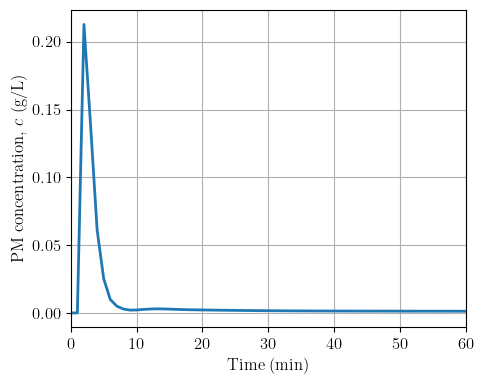

In [ ]:
def plot_avg_concentration():
    x_coords    = surf_half.points[:, 0]
    outlet_mask = (x_coords >= 2.3) & (x_coords <= x_coords.max())
    params      = tuple(sliders[n].value for n in ('λ', 'k', 'θ', 'C0', 'kd'))

    t_min   = np.arange(61, dtype=np.float32)          
    avg_c   = np.empty_like(t_min, dtype=np.float32)

    for i, t in enumerate(t_min * 60):                 
        avg_c[i] = predict_field(params, float(t))[outlet_mask].mean()

    plt.figure(figsize=(5, 4))
    plt.plot(t_min, avg_c, lw=2)
    plt.xlabel(r'Time (min)')
    plt.ylabel(r'PM concentration, $c$ (g/L)')
    plt.xlim(0, 60)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_avg_concentration()